### 0. Import util libraries


In [ ]:
import xarray as xr
import numpy as np
from matplotlib import rc

from inversion_sst_gp import (
    plot_helper,
    utils,
    gp_regression,
)

rc("font", family="serif", serif=["Computer Modern"])
rc("text", usetex=True)
rc("text.latex", preamble=r"\usepackage{amsmath}")

In [2]:
# Plotting parameters
lonlims = (115, 118)
latlims = (-15.5, -12.5)

### 1. Satellite case 1

#### 1.1. Prediction


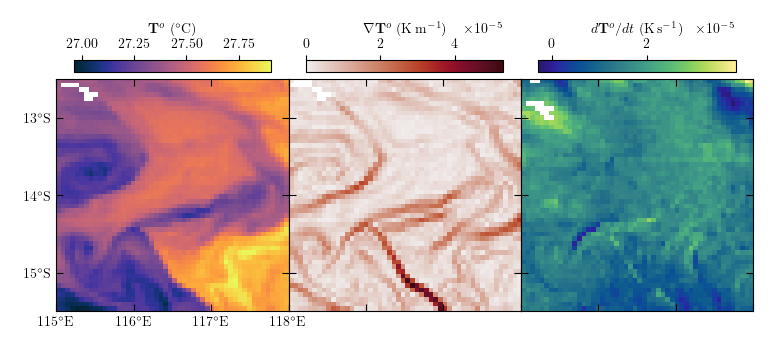

In [ ]:
# Load datasets
time_himawari_str = "2023-09-22T04:00:00"
time_altimetry_str = "2023-09-22T00:00:00"

# Load Himawari data
ds = xr.open_dataset("1_preproc_data/proc_data/himawari.nc").sel(
    time=np.datetime64(time_himawari_str)
)
time_step = ds.time_step.item()
lon, lat, To, dTdto = (ds[var].values for var in ("lon", "lat", "T", "dTdt"))
lonc, latc, X, Y, LON, LAT = utils.calculate_grid_properties(lon, lat)
dTds1o, dTds2o = utils.finite_difference_2d(X, Y, To)
plot_helper.visualize_data(
    LON, LAT, To, dTdto, dTds1o, dTds2o, lonlims=lonlims, latlims=latlims
)

In [ ]:
# Load altimetry current data
ds_altimetry = xr.open_dataset("1_preproc_data/proc_data/altimeter_currents.nc").sel(
    time=time_altimetry_str
)
lonr, latr, ugos, vgos = (
    ds_altimetry[var].values for var in ("lon", "lat", "ugos", "vgos")
)
_, _, Xr, Yr, LONr, LATr = utils.calculate_grid_properties(lonr, latr)

In [ ]:
# GP regression
params_fully_obs_gp = utils.extract_params(
    "2_covariance_parameter_estimation/outputs/satellite_gp_obs_t.csv",
    "time",
    time_himawari_str,
    type="gp",
)
muustar, muvstar, muSstar, stdustar, stdvstar, stdSstar, Kxstar_vel = (
    gp_regression.calculate_prediction_gpregression(
        dTds1o, dTds2o, dTdto, params_fully_obs_gp, X, Y, time_step
    )
)

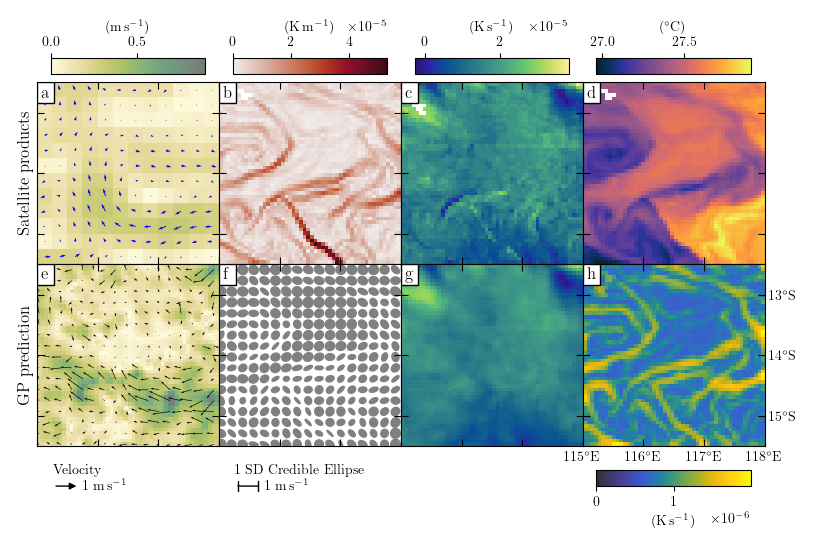

In [6]:
# Plot predictions
plot_helper.plot_predictions_osse(
    LON,
    LAT,
    To,
    dTds1o,
    dTds2o,
    dTdto,
    muSstar,
    Kxstar_vel,
    stdSstar,
    muustar,
    muvstar,
    lonlims,
    latlims,
    LONr=LONr,
    LATr=LATr,
    ur=ugos,
    vr=vgos,
    pscale=7,
    nx=17,
    ny=17,
)

#### 1.2. Dynamic Rossby number


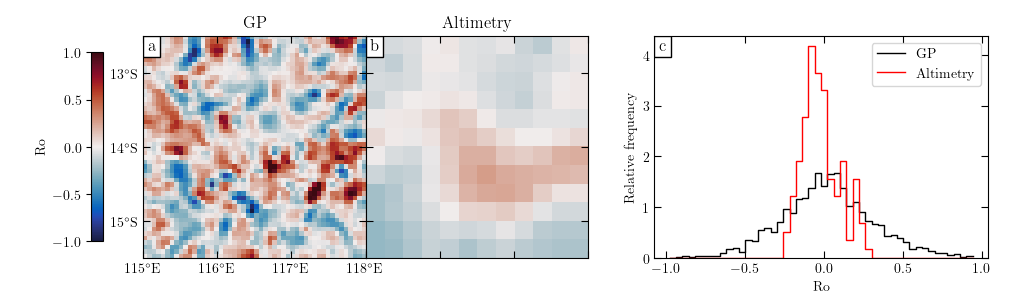

In [ ]:
Ro = utils.calculate_dynamic_rossby_number(X, Y, muustar, muvstar, LAT)
Ror = utils.calculate_dynamic_rossby_number(Xr, Yr, ugos, vgos, LATr)

plot_helper.plot_dynamic_rossby(
    LON,
    LAT,
    Ro,
    lonlims=lonlims,
    latlims=latlims,
    Ro_max=1,
    LONr=LONr,
    LATr=LATr,
    Ror=Ror,
)